<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Análise de Risco de Crédito direcionada por Modelagem Matemática e Estatística
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este Notebook concentra código fonte da Tese de Bacharelado do curso de Engenharia de Controle e Automação da UNESP Sorocaba desenvolvido pelo aluno Leonardo Aderaldo Vargas.  </i> 
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

Amostra baseada na base de dados do Lending Club Loan Data : https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv/data

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Lending Club é uma empresa de empréstimos peer-to-peer com sede nos EUA. Eles combinam pessoas que desejam investir dinheiro com pessoas que desejam pedir dinheiro emprestado. Quando os investidores investem o seu dinheiro através do Lending Club, esse dinheiro é repassado aos mutuários e, quando os mutuários pagam os seus empréstimos, o capital mais os juros são repassados ​​aos investidores. É uma vitória para todos, pois podem obter taxas de empréstimo normalmente mais baixas e retornos mais elevados para os investidores.</i>
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>O conjunto de dados Lending Club contém dados completos de empréstimos para todos os empréstimos emitidos entre 2007-2015, incluindo a situação atual do empréstimo (atual, atrasado, totalmente pago, etc.) e as informações de pagamento mais recentes. Os recursos (também conhecidos como variáveis) incluem pontuação de crédito, número de consultas financeiras, endereço incluindo códigos postais e estado, e cobranças, entre outros. As cobranças indicam se o cliente perdeu um ou mais pagamentos e a equipe está tentando recuperar o dinheiro. O arquivo é uma amostra da base de dados exposta.</i>
</p>  





# <font color='red' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid red;'>

In [39]:
# Importação das Bibliotecas e Parâmetros de Otimização
from functions import *
from tabulate import tabulate
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# Spark Session
from pyspark.sql import SparkSession, Row 
#from pyspark.sql.functions import * as F
import pyspark.sql.functions as F
spark = SparkSession.builder.getOrCreate()

# <font color='red' style='font-size: 40px;'> 1. Entendimento da Base de Dados </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição da Base de Dados </font>
<hr style='border: 2px solid green;'>

In [30]:
description = pd.read_excel('data/LCDataDictionary.xlsx')
display(description[['LoanStatNew', 'Descrição ']])

,LoanStatNew,Descrição
0,addr_state,O estado fornecido pelo mutuário no pedido de empréstimo
1,annual_inc,A renda anual declarada pelo próprio mutuário durante o registro.
2,annual_inc_joint,A renda anual combinada autodeclarada fornecida pelos co-mutuários durante o registro
3,application_type,Indica se o empréstimo é um pedido individual ou um pedido conjunto com dois co-mutuários
4,collection_recovery_fee,pós cobrança da taxa de cobrança
5,collections_12_mths_ex_med,Número de coletas em 12 meses excluindo coletas médicas
6,delinq_2yrs,O número de incidências de inadimplência vencidas há mais de 30 dias no arquivo de crédito do mutuário nos últimos 2 anos
7,desc,Descrição do empréstimo fornecida pelo mutuário
8,dti,"Uma razão calculada utilizando o total dos pagamentos mensais da dívida do mutuário sobre o total das obrigações da dívida, excluindo a hipoteca e o empréstimo em ML solicitado, dividido pelo rendimento mensal autodeclarado pelo mutuário."
9,dti_joint,"Um índice calculado usando o total de pagamentos mensais dos co-mutuários sobre o total das obrigações da dívida, excluindo hipotecas e o empréstimo em ML solicitado, dividido pela renda mensal combinada declarada pelos co-mutuários"


# <font color='green' style='font-size: 30px;'> 1.2) Definição da Target </font>
<hr style='border: 2px solid green;'>

> 1. A priori, deve-se definir de maneira clara as situações consideradas como Default 

> 2. A partir desta definição, deve-se criar a Target mostrando exatamente o que é um cliente Bom ou Ruim 

> 3. Escolheu-se o número "0" para representar o cliente Bom e o número "1" para representar o cliente Ruim, pois o evento de interesse é definir principalmente quem são os Maus Pagadores a fim de evitar ao máximo a inadimplêmcia

In [41]:
df = pd.read_parquet('data/credit_risk_loan_data.parquet')
df['loan_status'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']), 'BAD', 'GOOD') 

# <font color='green' style='font-size: 30px;'> 1.2) Separação em Treino e Teste </font>
<hr style='border: 2px solid green;'>

> 1. Antes de realizar as análises, deve-se separar em Treino e Teste a fim de simular um ambiente real

> 2. Ao separar antes de qualquer alteração, evita-se um erro muito grave denominado Data leakage

> 3. As análises serão realizadas unicamente sobre a base de Treinamento, simulando um ambiente real no qual a priori a base de Teste seria inexistente 

In [42]:
def separa_treino_teste(target, dados, size):
    x = dados.drop(target, axis = 1)
    y = dados[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= size, random_state = 42, shuffle=True)

    df_train = pd.concat([y_train, x_train], axis = 1)
    df_test = pd.concat([y_test, x_test], axis = 1)

    return df_train, df_test

df_train = separa_treino_teste('loan_status', df, 0.20)[0]
df_test = separa_treino_teste('loan_status', df, 0.20)[1]

print(f'Quantidade de Dados Utilizados para Treinamento: {df_train.shape[0]}')
print(f'Quantidade de Dados Utilizados para Teste: {df_test.shape[0]}')

Quantidade de Dados Utilizados para Treinamento: 373028
Quantidade de Dados Utilizados para Teste: 93257


# <font color='red' style='font-size: 40px;'> 2. Análise Univariada </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Distribuição de Bons (0) e Maus Clientes (1) </font>
<hr style='border: 2px solid green;'>

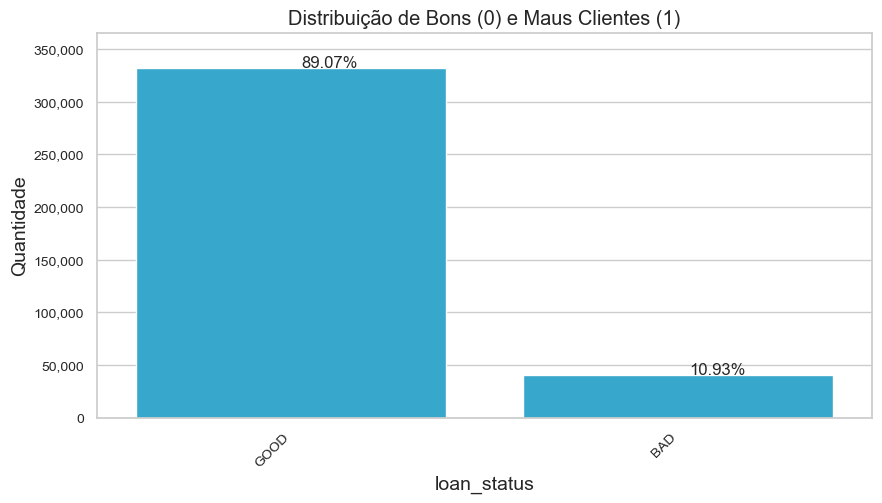

In [43]:
plota_barras(['loan_status'], False, df_train, 1, 1, 'Distribuição de Bons (0) e Maus Clientes (1)')

# <font color='red' style='font-size: 40px;'> 3. Análise Bivariada  </font>
<hr style='border: 2px solid red;'>